In [177]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [178]:
def logBin(degs, counts, num_bins=40):
    #based off of https://stackoverflow.com/questions/16489655/plotting-log-binned-network-degree-distributions
    x_max = np.log10(np.max(degs))
    y_max = np.log10(np.max(counts))
    base_max = np.max([x_max,y_max])
    x_min = np.log10(np.min(degs[degs != 0]))
    
    bins = np.logspace(x_min,base_max,num=num_bins)
    
    bin_means_y = (np.histogram(degs,bins,weights=counts)[0] / np.histogram(degs,bins)[0])
    bin_means_x = (np.histogram(degs,bins,weights=degs)[0] / np.histogram(degs,bins)[0])

    return bin_means_x,bin_means_y

100%|██████████| 200/200 [00:03<00:00, 58.91it/s] 


Network model:  Erdos-Reyni
---Degree measures---
max     239
mean    200.031
min     152

---Centrality measures---
Degree:
max     0.11955977988994497
mean    0.10006553276638319
min     0.07603801900950474

Closeness:
max     0.5317903697791966
mean    0.5263403873870499
min     0.5197607904316173


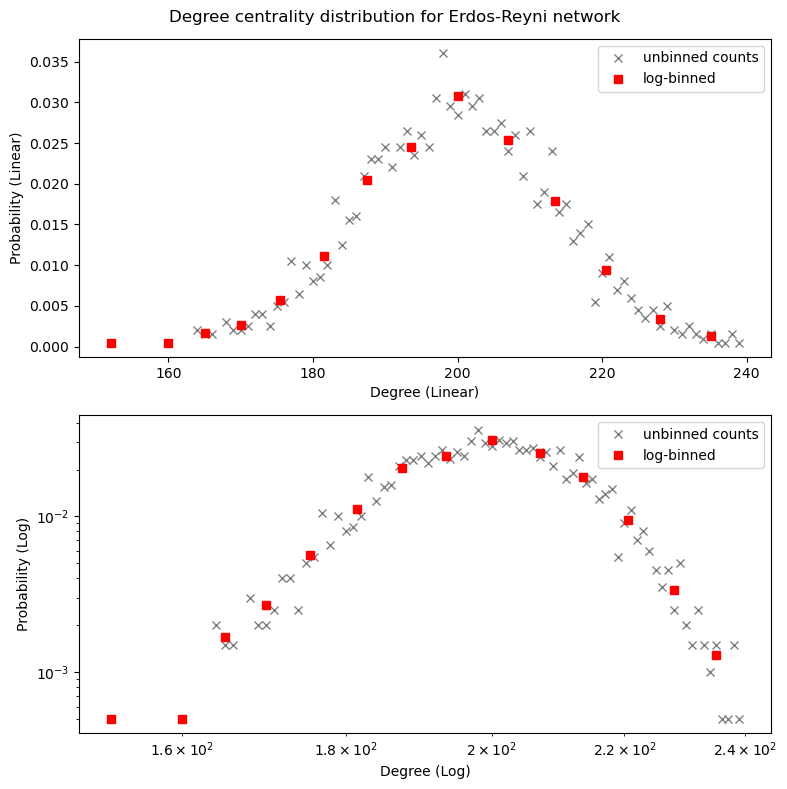

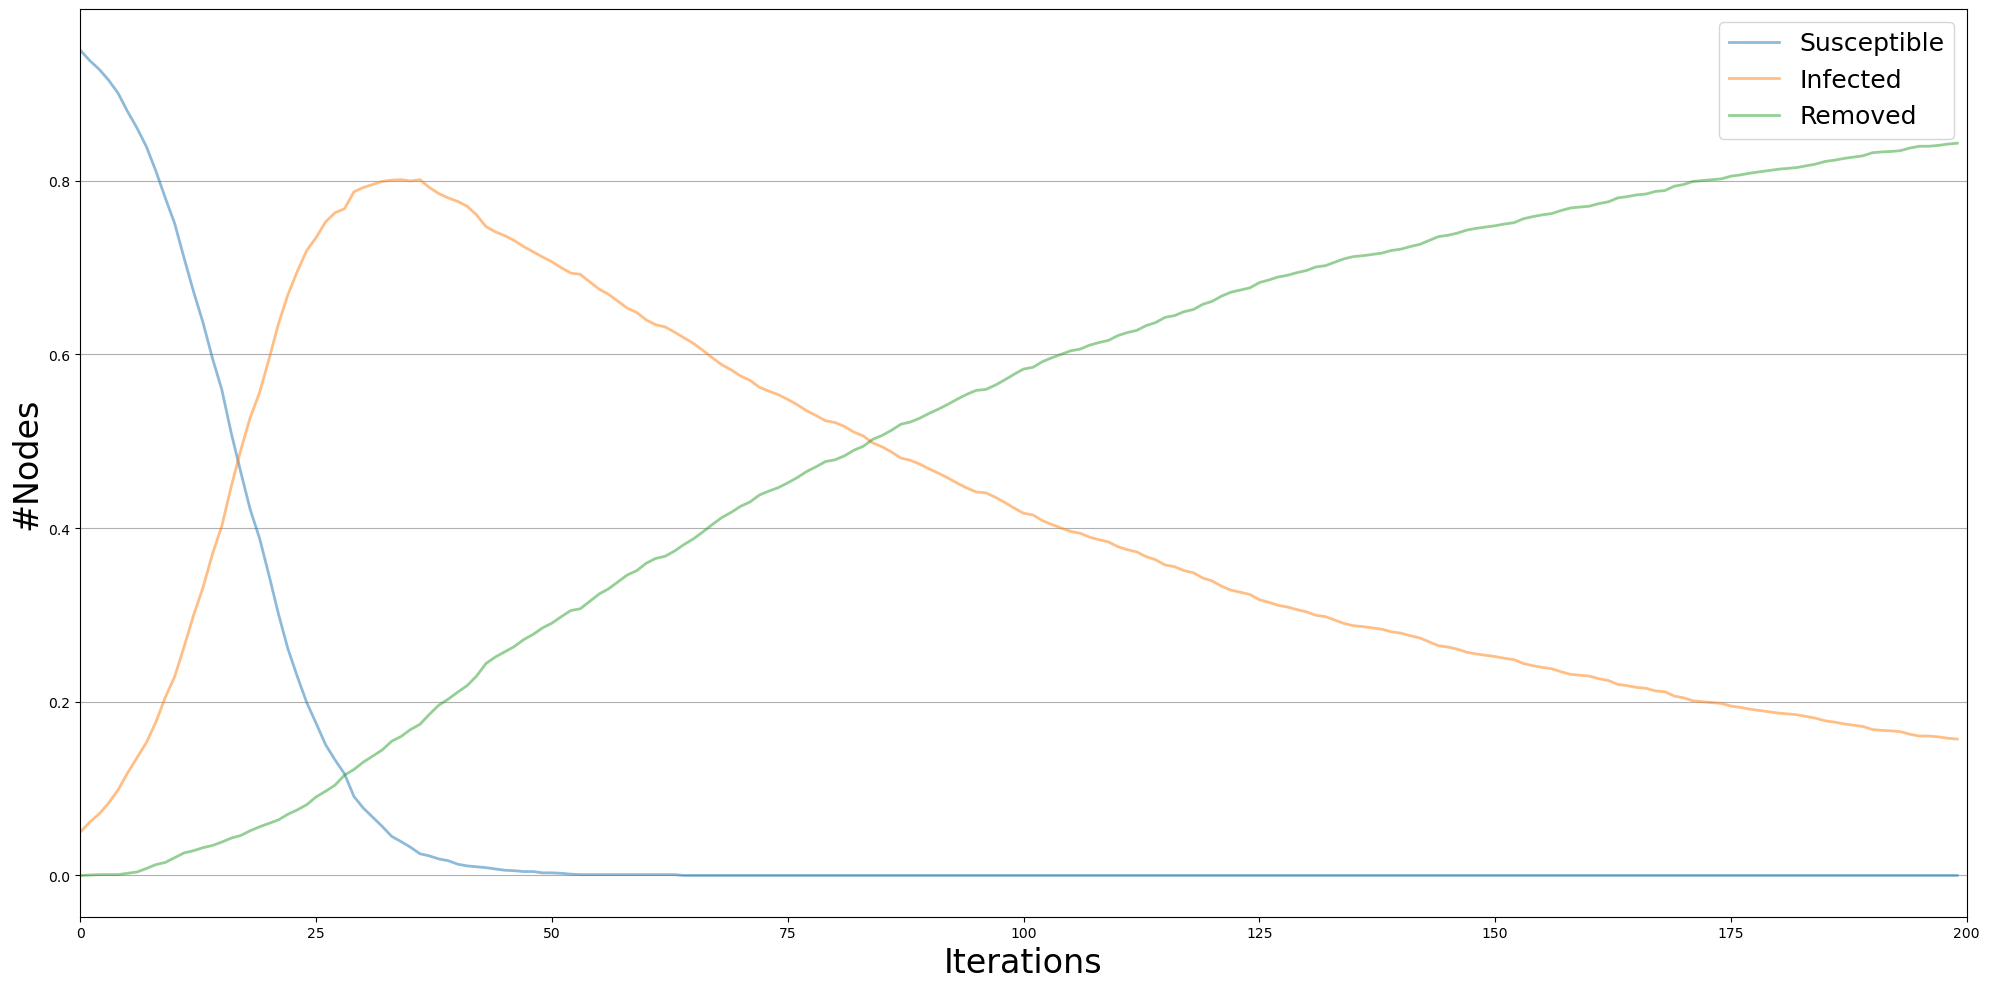

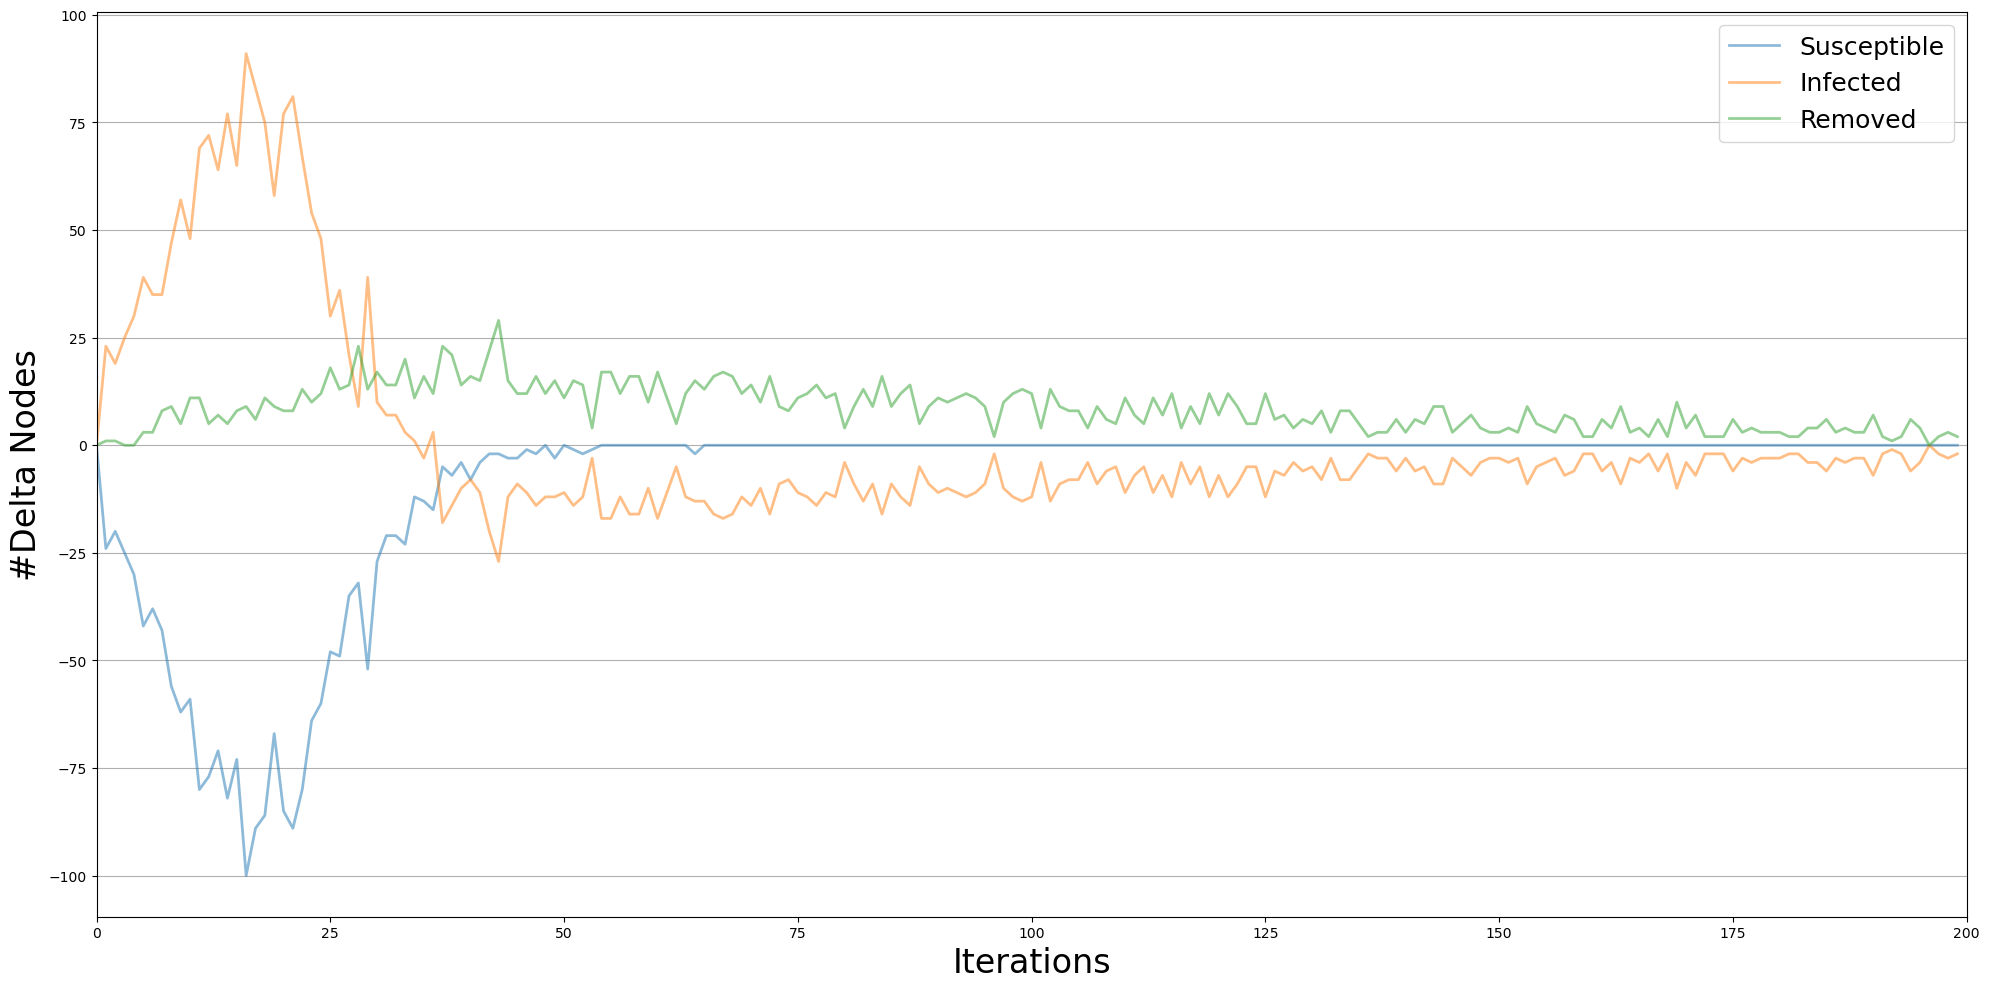

100%|██████████| 200/200 [00:02<00:00, 91.04it/s] 


Network model:  Watts-Strogatz
---Degree measures---
max     112
mean    100.0
min     87

---Centrality measures---
Degree:
max     0.056028014007003496
mean    0.05002501250625312
min     0.04352176088044022

Closeness:
max     0.47606572993569896
mean    0.4395431868863903
min     0.3979693410312562


/tmp/ipykernel_67177/3663660258.py:10: RuntimeWarning: invalid value encountered in divide
  bin_means_y = (np.histogram(degs,bins,weights=counts)[0] / np.histogram(degs,bins)[0])
/tmp/ipykernel_67177/3663660258.py:11: RuntimeWarning: invalid value encountered in divide
  bin_means_x = (np.histogram(degs,bins,weights=degs)[0] / np.histogram(degs,bins)[0])


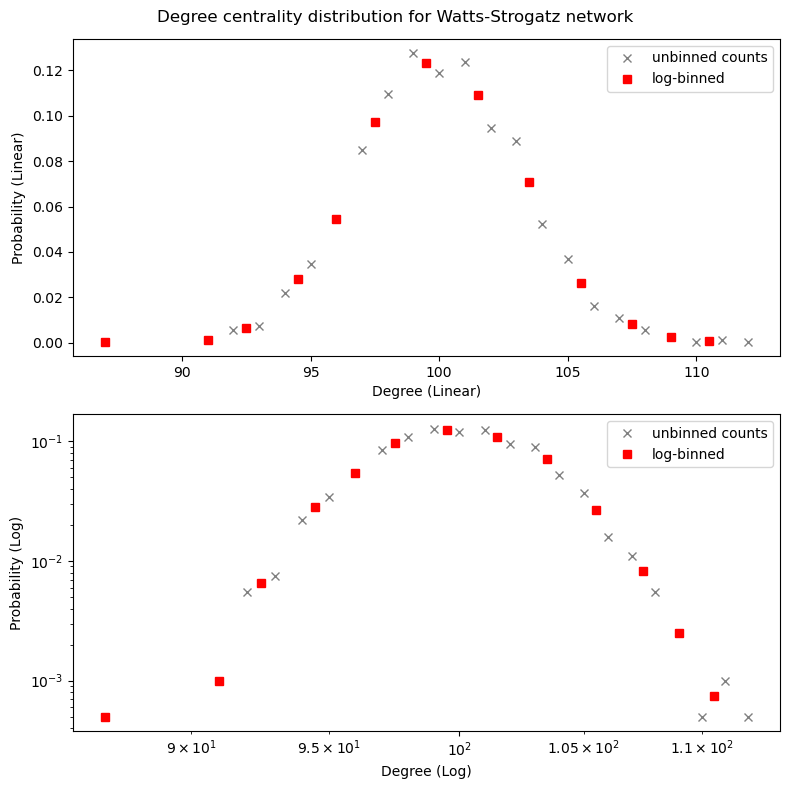

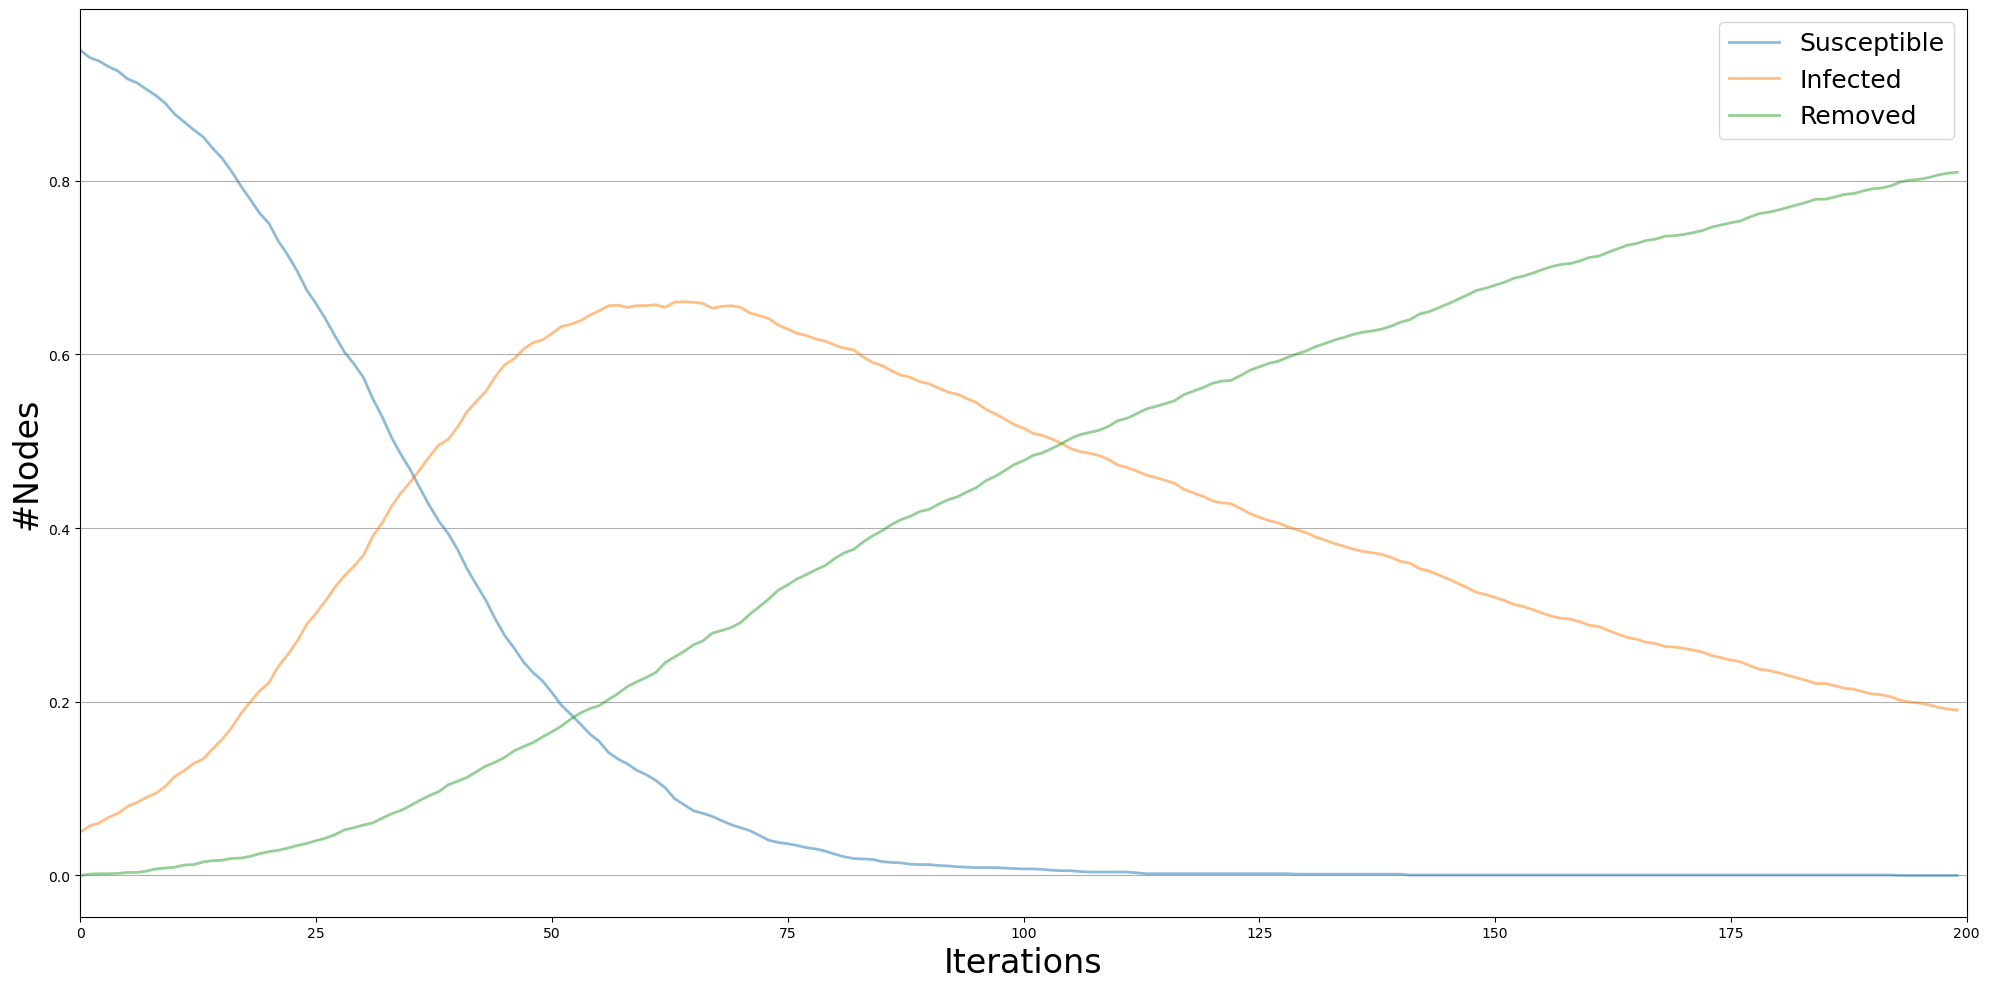

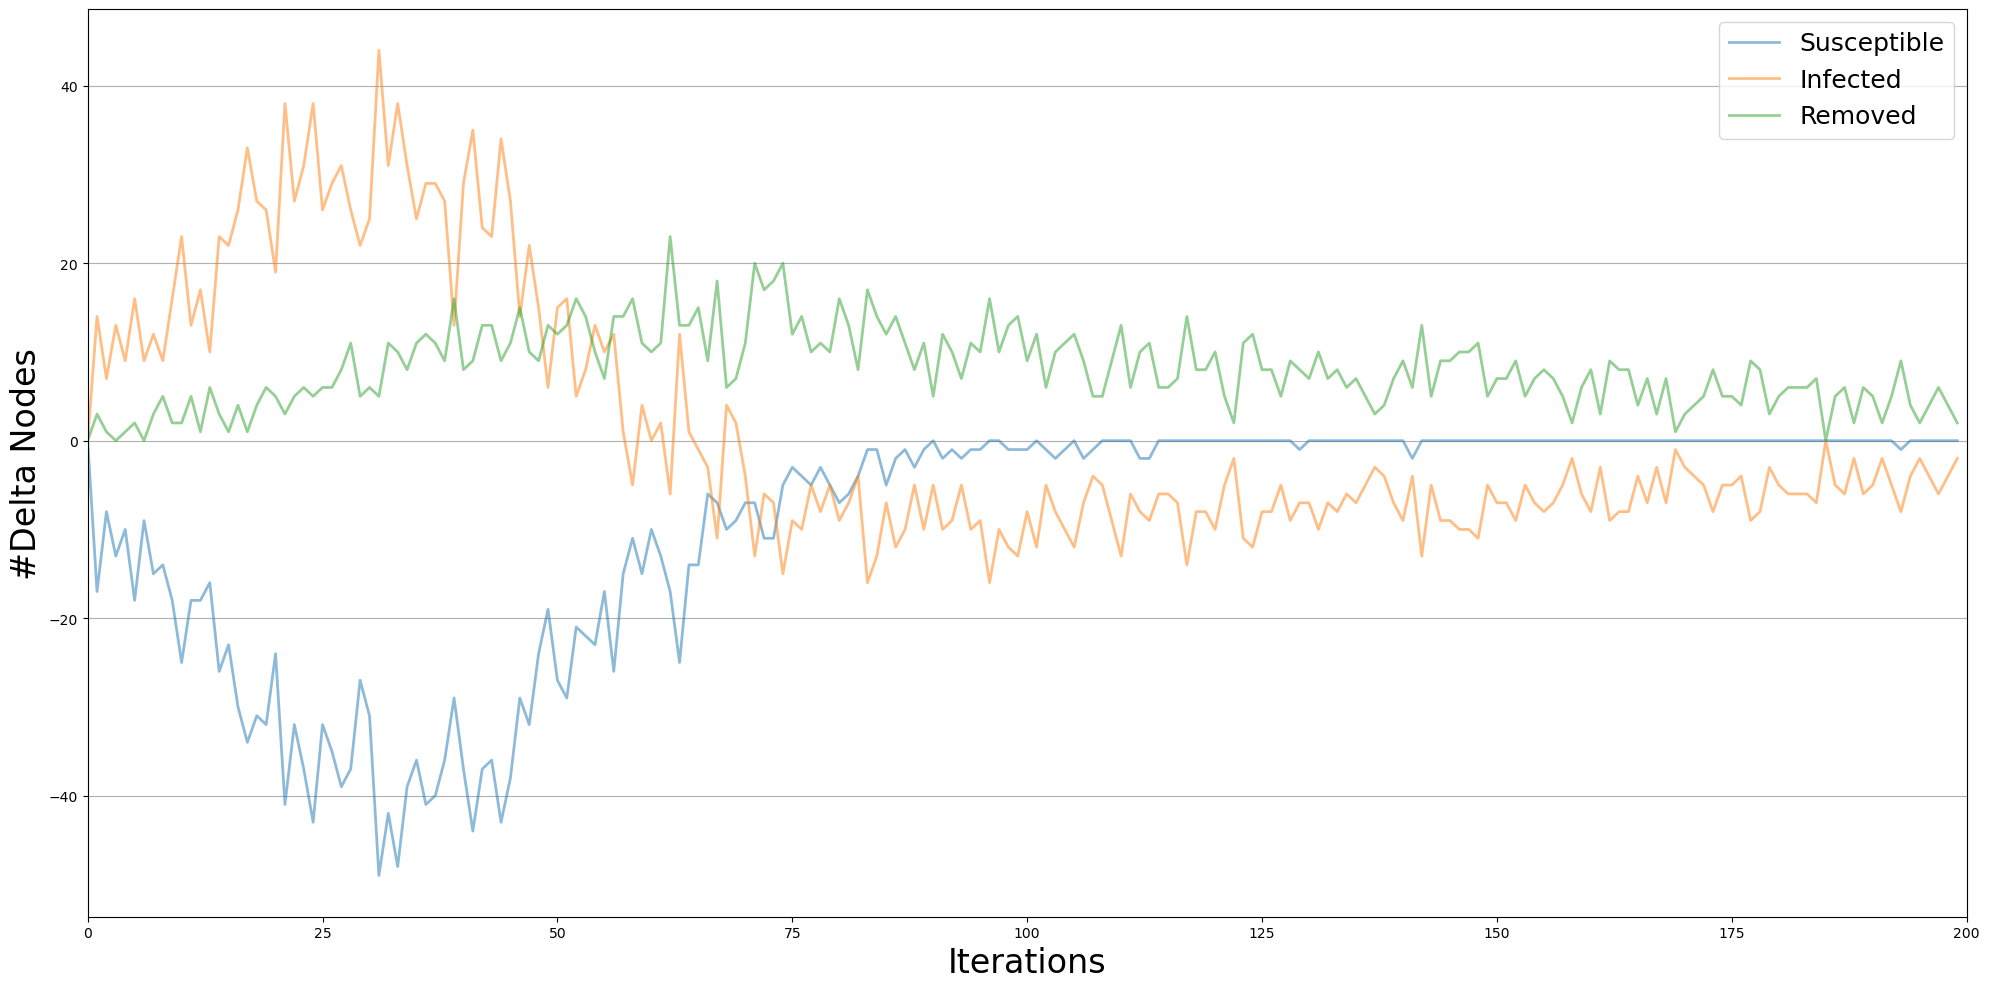

100%|██████████| 200/200 [00:03<00:00, 62.49it/s] 


Network model:  Barabasi Albert
---Degree measures---
max     608
mean    135.1
min     70

---Centrality measures---
Degree:
max     0.30415207603801897
mean    0.06758379189594797
min     0.03501750875437719

Closeness:
max     0.5896755162241888
mean    0.5172108972564914
min     0.5045431600201918


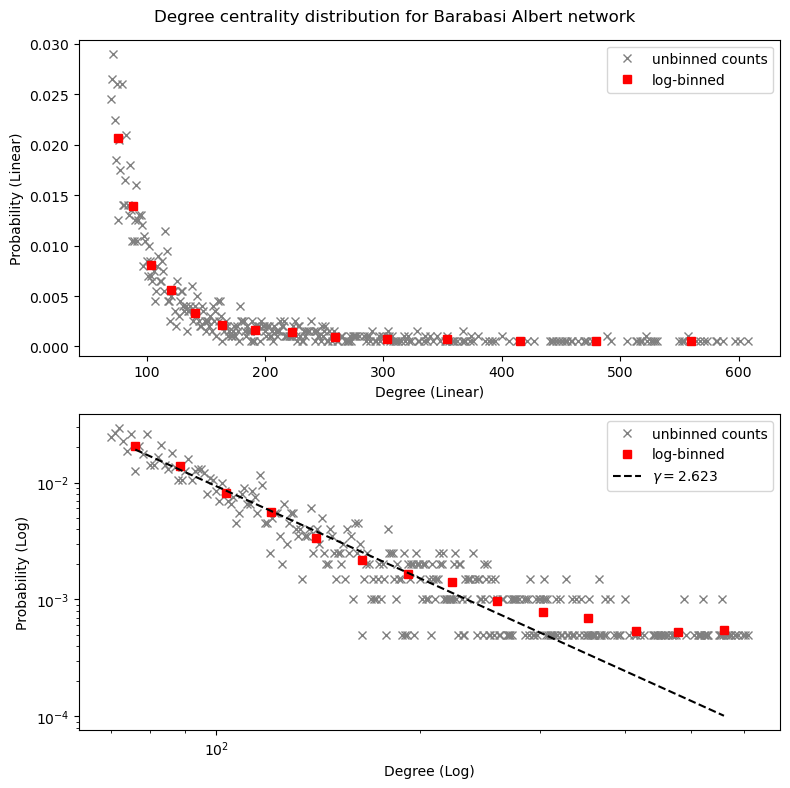

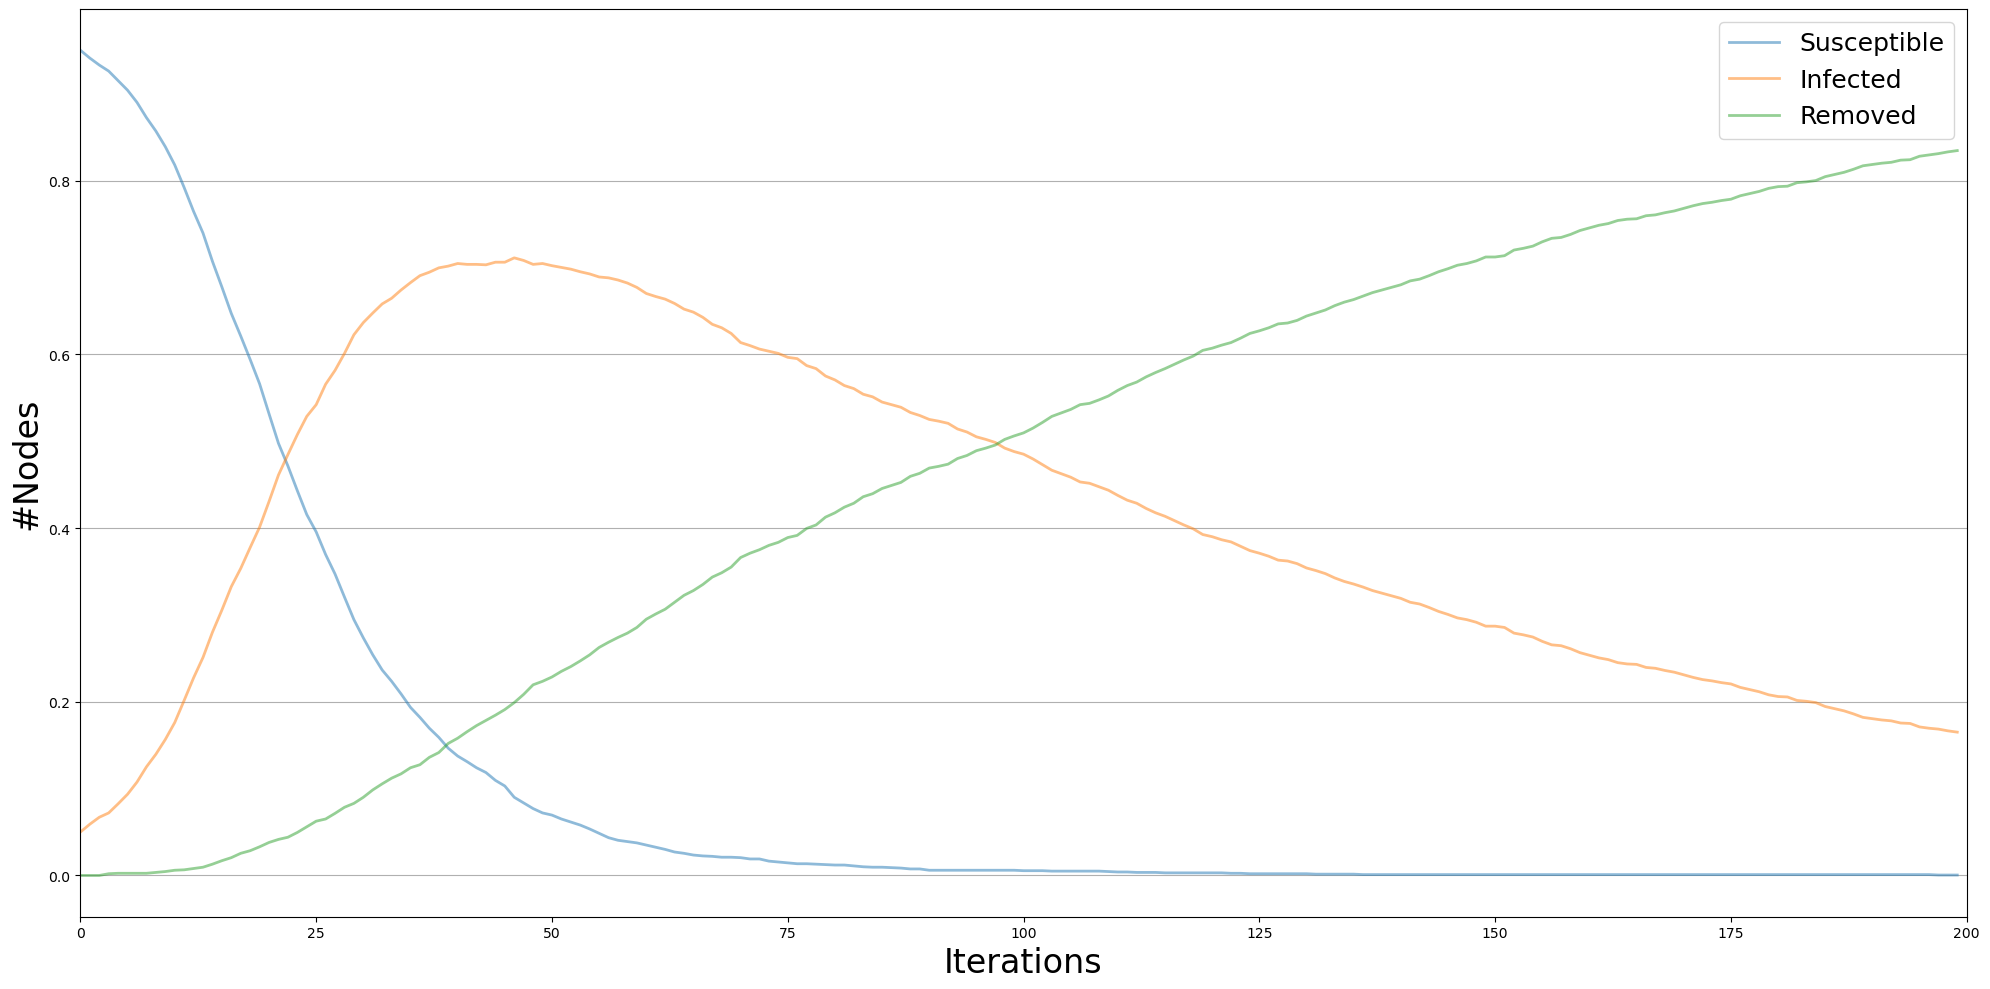

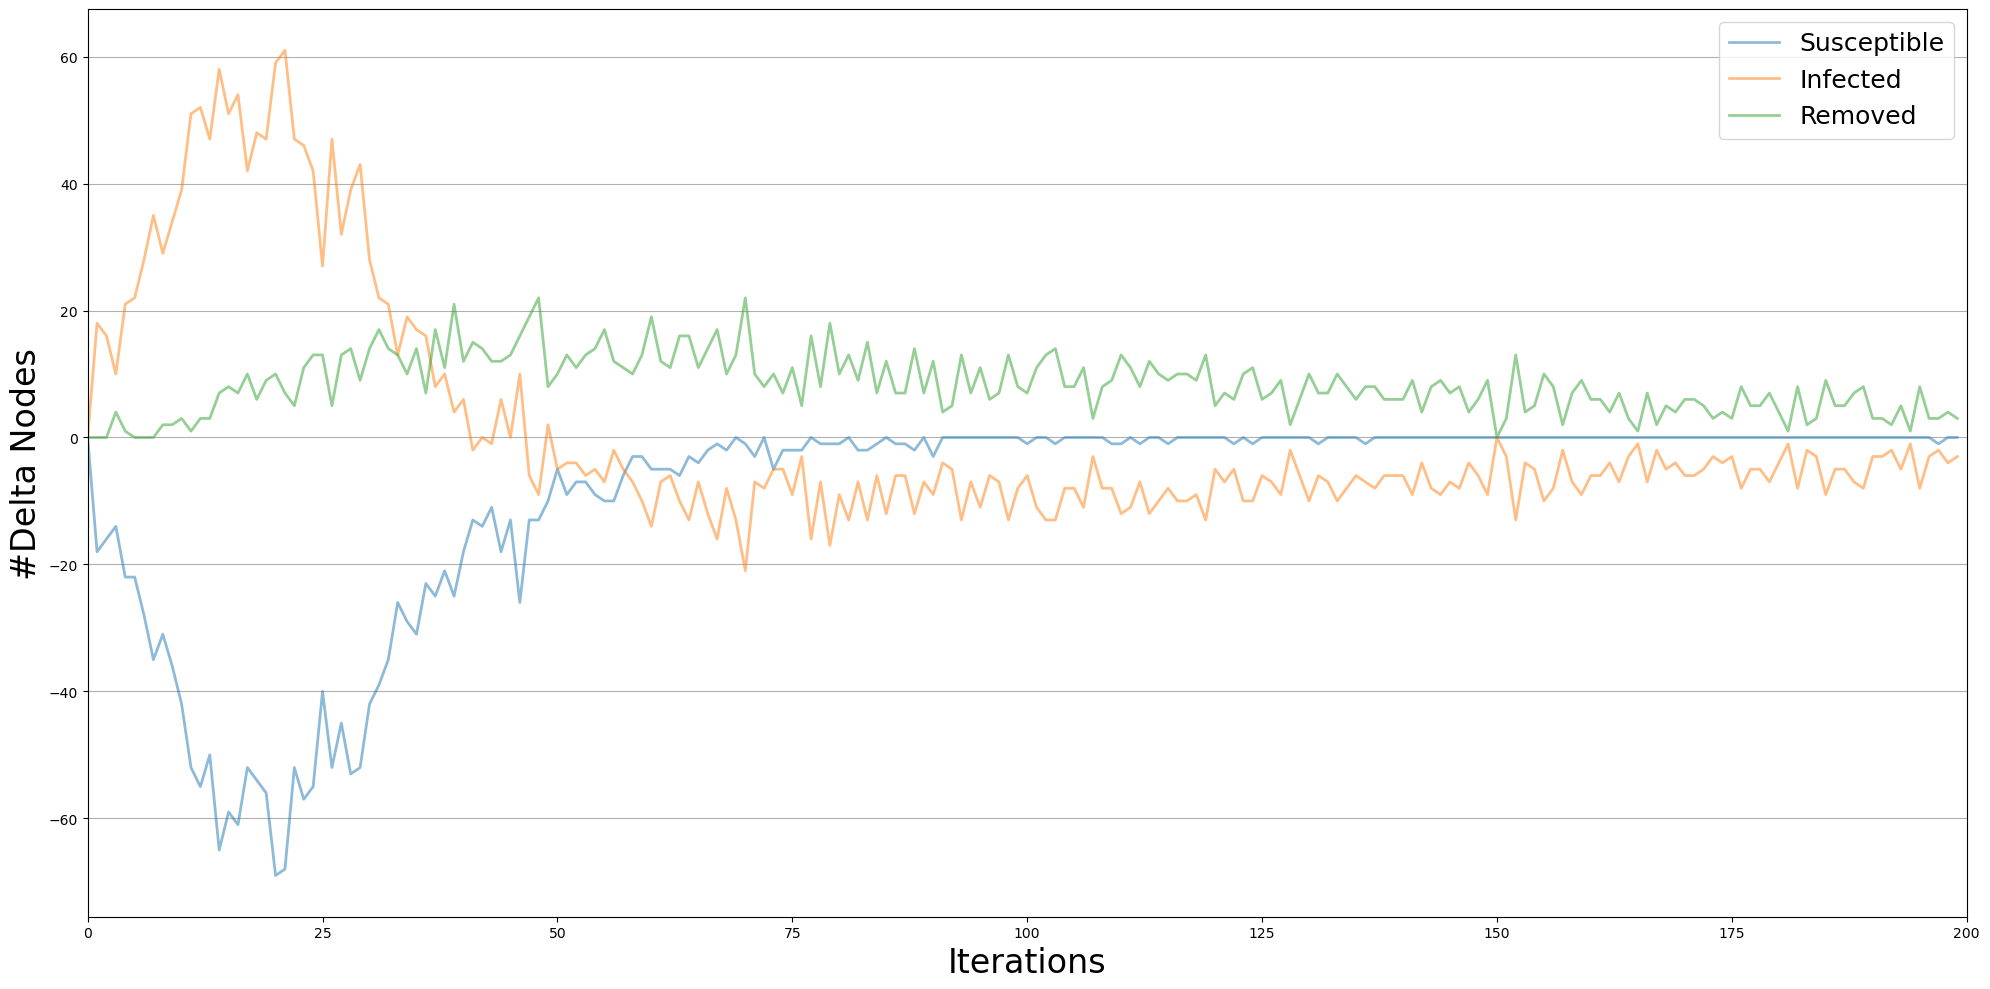

In [186]:
#Parameters
seed = 42

#Network parameters
n = 2000 # for all model types, (int) The number of nodes.
p = 0.1 # for Erdos-Reyni & Watts_strogatz, (float) Probability for edge creation & The probability of rewiring each edge, respectively.
k = 100 # for Watts_strogatz, (int) Each node is joined with its `k` nearest neighbors in a ring topology.
m = 70 # for Barabasi Albert, (int) Number of edges to attach from a new node to existing nodes.

#SIR parameters
sirBeta = 0.001
sirGamma = 0.01
fracI = 0.05
#Simulation parameters
numIterations = 200

# Network Definition
g0 = nx.erdos_renyi_graph(n, p, seed)
g1 = nx.watts_strogatz_graph(n, k, p, seed)
g2 = nx.barabasi_albert_graph(n, m, seed)
model_network_names = {g0 : 'Erdos-Reyni', g1 : 'Watts-Strogatz', g2 : 'Barabasi Albert'}

degree_sequence = np.zeros([3,n])
for g in [g0,g1,g2]:
    #average fraction that all nodes are connected to
    #high degree, betweenness and closeness, are probably most interesting measures for "interception" opportunities when vaccinating 
    
    # Model Definition
    model = ep.SIRModel(g,seed)
    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', sirBeta)
    config.add_model_parameter('gamma', sirGamma)
    config.add_model_parameter("fraction_infected", fracI)
    model.set_initial_status(config)
    
    # Simulation
    iterations = model.iteration_bunch(numIterations,progress_bar=True)
    trends = model.build_trends(iterations)
    
    #Setting up degree counts
    degree_sequence = sorted(d for n, d in g.degree())
    degs, deg_counts = np.unique(degree_sequence, return_counts=True)
    
    #Plotting
    print(f'Network model:  {model_network_names[g]}')
    print('---Degree measures---')
    print(f'max     {np.max(degree_sequence)}')
    print(f'mean    {np.mean(degree_sequence)}')
    print(f'min     {np.min(degree_sequence)}')
    print()
    print('---Centrality measures---')
    print('Degree:')
    deg_cent_vals = list(nx.degree_centrality(g).values())
    print(f'max     {np.max(deg_cent_vals)}')
    print(f'mean    {np.mean(deg_cent_vals)}')
    print(f'min     {np.min(deg_cent_vals)}')
    print()
    print('Closeness:')
    close_cent_vals = list(nx.closeness_centrality(g).values())
    print(f'max     {np.max(close_cent_vals)}')
    print(f'mean    {np.mean(close_cent_vals)}')
    print(f'min     {np.min(close_cent_vals)}')
    
    
    #Normalizing degree counts
    deg_counts = deg_counts/n
    #Log binning the degree counts
    x, y = logBin(degs, deg_counts, 15)
    
    #Plotting both binned and unbinned
    fig, ax = plt.subplots(2,1, figsize=[8,8])
    ax[0].plot(degs, deg_counts, 'x',color='grey',label='unbinned counts')
    ax[0].plot(x, y, 'rs', label='log-binned')
    ax[1].loglog(degs, deg_counts, 'x',color='grey',label='unbinned counts')
    ax[1].loglog(x, y, 'rs', label='log-binned')
    
    #Power law-ing the barabasi albert graph to see if it's scale-free
    if g == g2:
        m, b = np.polyfit(np.log(x[y>=0.001]), np.log(y[y>=0.001]), 1)
        ax[1].loglog(x,np.exp(m*np.log(x)+b), '--k',label=rf'$\gamma = {round(abs(m),3)}$')
    
    #More plotting
    fig.suptitle(f"Degree centrality distribution for {model_network_names[g]} network")
    ax[0].set_xlabel('Degree (Linear)')
    ax[1].set_xlabel('Degree (Log)')
    ax[0].set_ylabel('Probability (Linear)')
    ax[1].set_ylabel('Probability (Log)')
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    
    #Running the SIR model and plotting results
    viz = DiffusionTrend(model, trends)
    viz.plot()
    
    viz2 = DiffusionPrevalence(model, trends)
    viz2.plot()


#Resetting the model for next run
model.reset()

VARY G2 ENOUGH SO WE CAN EXPLORE CASES WHERE IT IS A SCALE-FREE NETWORK AND VICE VERSA
CHECK SECTION 4.7 OF ONLINE TEXTBOOK FOR REFERENCING